In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# Timer to measure the performance of methods
from time import time
# Import scipy to get sparse arrays
import scipy
from scipy import sparse
from scipy.sparse import linalg

## Diffusion equation

In [6]:
# Parameters
T  = 1
dt = 5e-5
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

# Array to hold values, storing all timesteps.
# (It's actually enough to store the current
# and the next timestep, but plotting is more
# convenient if we store all timesteps.)
U  = np.zeros((Nt, Nx))

#Stability condition
print('dt/dx**2 = ', dt/dx**2)

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

dt/dx**2 =  0.4990005


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Plot initial condition

(-0.2, 1.2)

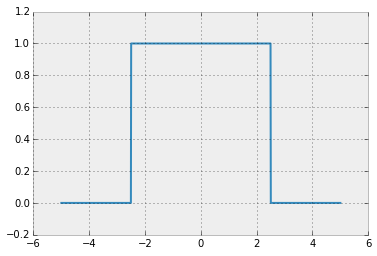

In [7]:
plt.plot(X, U[0,:])
plt.ylim(-0.2, 1.2)

# Explicit solver
### Set up matrix and carry out calculation

In [9]:
alpha = dt/dx**2
A = np.diag(alpha*np.ones(Nx-1), -1) + np.diag((1-2*alpha)*np.ones(Nx), 0) + np.diag(alpha*np.ones(Nx-1), 1)
tic = time()
for t in range(1, Nt):
    U[t,:] = np.dot(A, U[t-1,:])
toc = time()
print('Time: ', toc - tic)

Time:  11.478390216827393


(-0.2, 1.2)

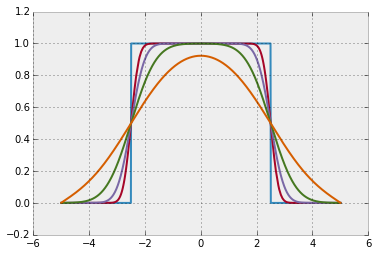

In [10]:
# Plot for various timesteps
plt.plot(X, U[0,:])
plt.plot(X, U[500,:])
plt.plot(X, U[1500,:])
plt.plot(X, U[5000,:])
plt.plot(X, U[19999,:])
plt.ylim(-0.2, 1.2)

### What happens when the timestep is too large?

In [12]:
T  = 1
dt = 2.4e-4
Nt = int(T/dt)
Nx = 500
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

U  = np.zeros((Nt, Nx))

#Stability condition
print(dt/dx**2)

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
A = np.diag(alpha*np.ones(Nx-1), -1) + np.diag((1-2*alpha)*np.ones(Nx), 0) + np.diag(alpha*np.ones(Nx-1), 1)
for t in range(1, Nt):
    U[t,:] = np.dot(A, U[t-1,:])

0.5976024


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


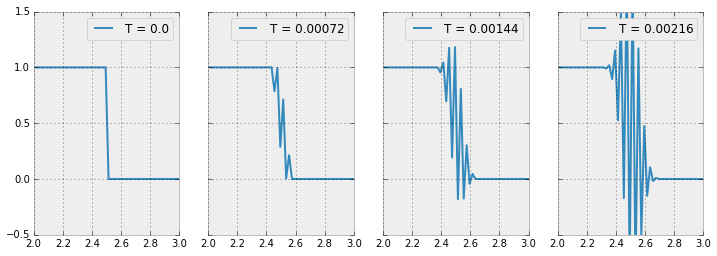

In [14]:
# Plot only a small part, one edge of the top hat profile,
# in order to see details.
# Errors grow exponentially

fig, ax = plt.subplots(1,4, sharey = True, figsize = (12, 4))
for i in range(len(ax)):
    t = 3*i
    ax[i].plot(X, U[t,:], label = 'T = %s' % (dt*t))
    ax[i].set_ylim(-0.5, 1.5)
    ax[i].set_xlim(2,3)
    ax[i].legend()


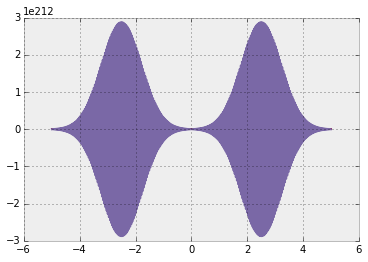

In [17]:
# plot entire solution, showing that it's just
# huge numbers. 
plt.plot(X, U[0,:])
plt.plot(X, U[500,:])
plt.plot(X, U[1500,:])


### Sparse array structure

The calculations can be done much faster with a sparse array structure and corresponding matrix multiplication function

In [19]:
T  = 1
#dt = 2.5e-4
dt = 5e-5
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

U  = np.zeros((Nt, Nx))

#Stability condition
#print(dt/dx**2)

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

# Set up matrix A, now using sparse array
alpha = dt/dx**2
A = np.diag(alpha*np.ones(Nx-1), -1) + np.diag((1-2*alpha)*np.ones(Nx), 0) + np.diag(alpha*np.ones(Nx-1), 1)
# dia_matrix is a sparse structure for diagonal-type matrices
A = sparse.dia_matrix(A)
tic = time()
for t in range(1, Nt):
    # The .dot method of the dia_matrix type implements
    # matrix multiplication for this datatype
    U[t,:] = A.dot(U[t-1,:])
toc = time()
print('Time: ', toc - tic)

Time:  0.5350041389465332


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.2, 1.2)

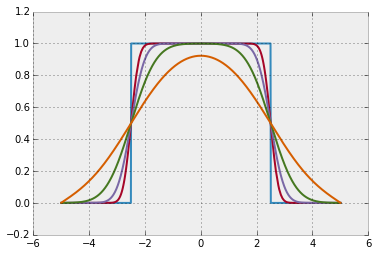

In [20]:
# Plot solution for various timesteps
plt.plot(X, U[0,:])
plt.plot(X, U[500,:])
plt.plot(X, U[1500,:])
plt.plot(X, U[5000,:])
plt.plot(X, U[19999,:])
plt.ylim(-0.2, 1.2)

# Implicit solver

Here we use an implicit solver, and find U by calculating the inverse of A once, then using this in each timestep. The implicit scheme allows much larger timestep.

In [21]:
T  = 1
dt = 1e-2
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

U  = np.zeros((Nt, Nx))

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
A = np.diag(-alpha*np.ones(Nx-1), -1) + np.diag((1+2*alpha)*np.ones(Nx), 0) + np.diag(-alpha*np.ones(Nx-1), 1)
Ainv = np.linalg.inv(A)
tic = time()
for t in range(1, Nt):
    U[t,:] = np.dot(Ainv, U[t-1,:])
toc = time()
print('Time: ', toc - tic)

Time:  0.05854201316833496


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.2, 1.2)

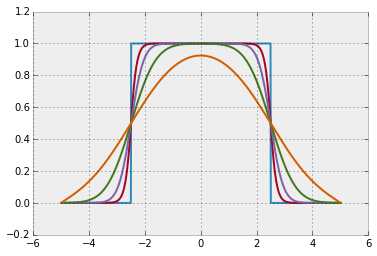

In [23]:
# Plot solution for various timesteps

plt.plot(X, U[0,:])
plt.plot(X, U[2,:])
plt.plot(X, U[7,:])
plt.plot(X, U[25,:])
plt.plot(X, U[99,:])
plt.ylim(-0.2, 1.2)

# Crank-Nicolson

### Using inversion

In [34]:
T  = 1
dt = 1e-3
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

print('Nt: ', Nt)

U  = np.zeros((Nt, Nx))

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
B = np.diag(-np.ones(Nx-1), -1) + np.diag(2*np.ones(Nx), 0) + np.diag(-np.ones(Nx-1), 1)
L = 2*np.identity(Nx) + alpha*B
R = 2*np.identity(Nx) - alpha*B
Linv = np.linalg.inv(L)
C = np.dot(Linv, R)
tic = time()
for t in range(1, Nt):
    U[t,:] = np.dot(C, U[t-1,:])
toc = time()
print('Time: ', toc - tic)

Nt:  1000
Time:  0.6211409568786621


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.2, 1.2)

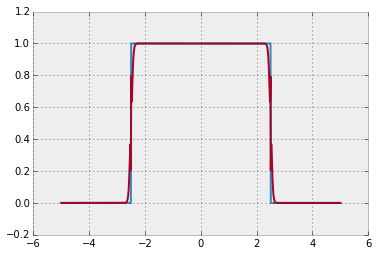

In [36]:
plt.plot(X, U[0,:])
plt.plot(X, U[2,:])
#plt.plot(X, U[7,:])
#plt.plot(X, U[25,:])
#plt.plot(X, U[99,:])
plt.ylim(-0.2, 1.2)

### Using direct solver

In [216]:
T  = 1
dt = 1e-3
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

print('Nt: ', Nt)

U  = np.zeros((Nt, Nx))

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
B = np.diag(-np.ones(Nx-1), -1) + np.diag(2*np.ones(Nx), 0) + np.diag(-np.ones(Nx-1), 1)

L = 2*np.identity(Nx) + alpha*B

tic = time()
for t in range(1, Nt):
    R = np.dot(2*np.identity(Nx) - alpha*B, U[t-1,:])
    U[t,:] = np.linalg.solve(L, R)
toc = time()
print('Time: ', toc - tic)

Nt:  1000
Time:  48.69015622138977


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.2, 1.2)

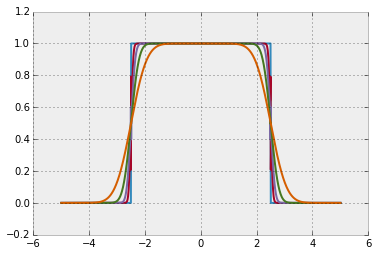

In [217]:
plt.plot(X, U[0,:])
plt.plot(X, U[2,:])
plt.plot(X, U[7,:])
plt.plot(X, U[25,:])
plt.plot(X, U[99,:])
plt.ylim(-0.2, 1.2)

### Using LU factorisation

In [220]:
T  = 1
dt = 1e-3
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

print('Nt: ', Nt)

U  = np.zeros((Nt, Nx))

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
B = np.diag(-np.ones(Nx-1), -1) + np.diag(2*np.ones(Nx), 0) + np.diag(-np.ones(Nx-1), 1)

L = 2*np.identity(Nx) + alpha*B
lu, piv = scipy.linalg.lu_factor(L)

tic = time()
for t in range(1, Nt):
    R = np.dot(2*np.identity(Nx) - alpha*B, U[t-1,:])
    U[t,:] = scipy.linalg.lu_solve((lu, piv), R)
toc = time()
print('Time: ', toc - tic)

Nt:  1000
Time:  15.838773965835571


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
plt.plot(X, U[0,:])
plt.plot(X, U[2,:])
plt.plot(X, U[7,:])
plt.plot(X, U[25,:])
plt.plot(X, U[99,:])
plt.ylim(-0.2, 1.2)

### Using sparse solver from scipy

In [225]:
T  = 1
dt = 1e-3
Nt = int(T/dt)
Nx = 1000
X0 = -5
X1 = 5
X  = np.linspace(X0, X1, Nx)
dx = X[1] - X[0]

print('Nt: ', Nt)

U  = np.zeros((Nt, Nx))

# Initial condition - top hat profile
U[0,Nx/4:3*Nx/4] = 1

alpha = dt/dx**2
B = np.diag(-np.ones(Nx-1), -1) + np.diag(2*np.ones(Nx), 0) + np.diag(-np.ones(Nx-1), 1)

L = 2*np.identity(Nx) + alpha*B
L = scipy.sparse.csr_matrix(L)

tic = time()
for t in range(1, Nt):
    R = np.dot(2*np.identity(Nx) - alpha*B, U[t-1,:])
    U[t,:] = scipy.sparse.linalg.spsolve(L, R)
toc = time()
print('Time: ', toc - tic)

Nt:  1000
Time:  13.916211128234863


/Users/nordam/.pyenv/versions/3.4.2/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
